In [54]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
def get_model(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(units=128, input_shape=(input_shape,), activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [56]:
data = pd.read_csv('pocasi.csv')

X = data[['teplota', 'rychlost_vitr', 'vlhkost', 'tlak', 'mesic']].values
y = data['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Z-Score normalization
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

model = get_model(X_train.shape[1])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)

print("Predictions:", predictions_binary.flatten())

Epoch 1/20


c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6088 - loss: 0.6500 - val_accuracy: 0.5789 - val_loss: 0.6086
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6751 - loss: 0.5553 - val_accuracy: 0.6382 - val_loss: 0.5724
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7276 - loss: 0.5338 - val_accuracy: 0.6711 - val_loss: 0.5505
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7561 - loss: 0.5168 - val_accuracy: 0.7039 - val_loss: 0.5411
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7522 - loss: 0.5089 - val_accuracy: 0.7237 - val_loss: 0.5291
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7617 - loss: 0.5095 - val_accuracy: 0.7237 - val_loss: 0.5182
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7324 - loss: 0.5327 - val_accuracy: 0.7303 - val_loss: 0.5196
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7647 - loss: 0.5006 - val_accuracy: 0.7303 - val_loss: 0.5151
Ep

In [57]:
def visualize_neural_network(model, layer_names=None):
    """
    Visualize the neural network architecture with nodes and edges.

    Parameters:
    - model: Keras model to visualize
    - layer_names: Optional list of custom names for layers
    """
    # Get the model structure
    layers_list = model.layers

    # Get layer dimensions using get_config or model.summary
    # Input layer size is the first dimension of the input shape
    input_dim = model.input_shape[1]  # Get input dimension from model

    # For each layer, get its output dimension
    layer_dims = [input_dim]  # Start with input dimension
    for layer in layers_list:
        if hasattr(layer, 'units'):  # For Dense layers
            layer_dims.append(layer.units)
        elif isinstance(layer, tf.keras.layers.Dropout):  # For Dropout layers, use previous dimension
            layer_dims.append(layer_dims[-1])
        else:  # For other layer types
            # Try to get output shape if available
            if hasattr(layer, 'output_shape') and layer.output_shape:
                try:
                    layer_dims.append(layer.output_shape[1])
                except (IndexError, TypeError):
                    # If can't determine shape, use previous dimension
                    layer_dims.append(layer_dims[-1])
            else:
                layer_dims.append(layer_dims[-1])

    # If no custom names are provided, use default names
    if layer_names is None:
        layer_names = ['Input']
        for i, layer in enumerate(layers_list):
            if hasattr(layer, 'activation') and layer.activation:
                act_name = layer.activation.__name__ if callable(layer.activation) else str(layer.activation)
                layer_names.append(f'{layer.__class__.__name__} ({act_name})')
            else:
                layer_names.append(f'{layer.__class__.__name__}')

    # Set up the plot
    plt.figure(figsize=(12, 8))
    plt.title('Neural Network Architecture')

    # Normalize position for layers
    layer_positions = np.linspace(0, 1, len(layer_dims))

    # Colors for nodes and edges
    node_color = '#428bca'         # Blue for nodes
    edge_color = '#bbbbbb'         # Light grey for edges
    dropout_color = '#ff7f0e'      # Orange for dropout layers

    # Draw the nodes and edges
    for i, layer_size in enumerate(layer_dims):
        # Normalize position for nodes in the layer
        if layer_size > 10:  # If too many nodes, show just a sample
            node_positions = np.linspace(0, 1, 10)
            node_text = f"{layer_size} neurons"
            show_text = True
        else:
            node_positions = np.linspace(0, 1, layer_size)
            node_text = ""
            show_text = False

        # Check if the current layer is a dropout layer
        is_dropout = i > 0 and i <= len(layers_list) and isinstance(layers_list[i-1], tf.keras.layers.Dropout)
        current_node_color = dropout_color if is_dropout else node_color

        # Draw nodes for this layer
        for j, node_pos in enumerate(node_positions):
            # Add node
            circle = plt.Circle((layer_positions[i], node_pos), 0.02, color=current_node_color, zorder=4)
            plt.gca().add_patch(circle)

            # Connect to previous layer
            if i > 0:
                if layer_dims[i-1] > 10:  # Previous layer has many nodes
                    prev_node_positions = np.linspace(0, 1, 10)
                else:
                    prev_node_positions = np.linspace(0, 1, layer_dims[i-1])

                for prev_pos in prev_node_positions:
                    plt.plot([layer_positions[i-1], layer_positions[i]], [prev_pos, node_pos], '-', color=edge_color, linewidth=0.5, zorder=1)

        # If showing text for number of neurons
        if show_text:
            plt.text(layer_positions[i], 0.5, node_text, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9))

    # Add layer names
    for i, name in enumerate(layer_names):
        plt.text(layer_positions[i], 1.1, name, ha='center', va='center')

    # Customize plot
    plt.grid(False)
    plt.axis('off')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.2)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=node_color, label='Regular Neurons'),
        Patch(facecolor=dropout_color, label='Dropout Neurons'),
        Patch(facecolor=edge_color, label='Connections')
    ]
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

    plt.tight_layout()
    plt.show()

    # Print model summary for additional details
    print("\nModel Summary:")
    model.summary()

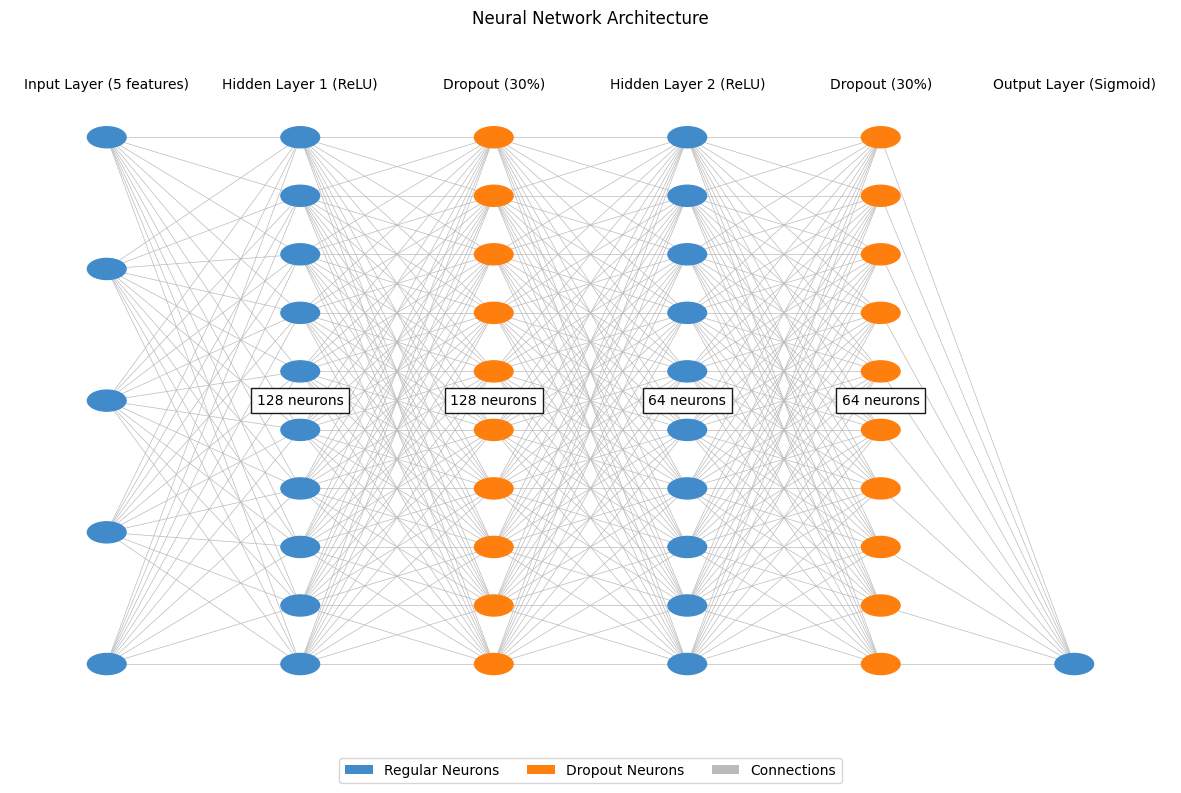


Model Summary:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,269 (106.52 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,180 (71.02 KB)

In [58]:
# Visualize the neural network architecture
visualize_neural_network(model, layer_names=['Input Layer (5 features)', 'Hidden Layer 1 (ReLU)', 'Dropout (30%)', 'Hidden Layer 2 (ReLU)', 'Dropout (30%)', 'Output Layer (Sigmoid)'])